In [104]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import time

# Integer Program Formulation
This notebook outlines an integer programming perspective on the Covid-19 scheduling problem. In its current iteration, this model schedules people on a week-by-week basis, ensuring that people take $F_i = 2$ tests per week (if feasible, i.e. available at least 2 days) and attempting to keep the number of tests on any given day below a reasonable bound.

Our latest iteration involves splitting up a day into $n\_blocks = 3$ blocks and scheduling people to test at some point during one of the blocks. Therefore the optimized variable is $assignment$, a $(n\_people, n\_blocks \times n\_days)$ binary matrix where each row is the schedule for one person. Every $n\_blocks$ entries represents one day, and a 0 in one entry means no test on that block, 1 means test. We can incorporate $avail$, which is a $(n\_people, n\_blocks \times n\_days)$ binary matrix that marks when people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and computing the row-sums gives a $ n\_people $ vector with the counts of well-scheduled tests that $n\_days$ (usually week) for each person. Moreover, computing the column-sums $ assignment$ gives the total number of tests per block, which we want to keep fairly even.

<!-- The optimized variable is $assignment$, a $(n\_people, n\_days)$ binary matrix where each row is the weekly schedule for one person, where 0 means 'no test' and 1 means 'test'. We can incorporate $avail$, which is a $(n\_people, n\_days)$ binary matrix that marks on which days people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and summing across rows gives a $ n\_people $ vector with the counts of well-scheduled tests that week for each person. Moreover, summing $ assignment$ across columns gives the total number of tests per day, which we want to keep fairly even. -->

# setup

One important aspect is creating a realistic schedule on which to test our model. It's not as simple as just letting everyone have random availability. It would be nice to have a tool that allows you to tweak the specific scheduling parameters for different campuses. Here are things we should consider:
* Split campus community members into three groups — students, faculty, staff
* A large proportion of students should be available 7 days a week, since they live on campus
* The rest of the students should be available on the weekends and either on MWF or TTh (this is at least the case at UChicago — should investigate more)
* Professors should be available 1-2 days a week, never on weekends
  * If 2 days a week, not consecutive days?
* Staff ??? depends on the staff, need to think more about this.

In [213]:
def runTrial(n_trials, n_people, n_blocks, buffer, n_days=7, test_interval=3.5, pcts=[.7,.2,.1]):
    n_people = n_people
    n_blocks = n_blocks
    buffer = buffer
    n_tests = n_days / test_interval # corresponds to F_i

    times = []
    spreads = []
    maxDevs = []
    infeasibles = 0
    for t in range(n_trials):
        if (t%10 == 0):
            print(t)
        avail, b, beq, spaces, bb = runSetup(pcts, n_people, n_days, n_blocks, n_tests)
        adjacencies, sameDays = make_constraints(n_days, n_blocks)
        start = time.perf_counter()
        assignment = runOpt(n_people, n_days, n_blocks, avail, bb, beq, spaces, buffer)
        end = time.perf_counter()
        if assignment.value is not None:
            spreadScore, block_demands, max_deviation = analyze(assignment, n_people, n_days, n_blocks, n_tests)
#             print("Optimization done")
            times.append(end-start)
            spreads.append(spreadScore)
            maxDevs.append(max_deviation)
        else:
#             print("Situation infeasible")
            infeasibles += 1
    print("There were %d infeasibles" % infeasibles)
          
    return times, spreads, maxDevs

In [208]:
def plotTrials(ts, ss, mds, buffer, test_interval, n_people, n_blocks, n_trials):
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    fig.suptitle("%d people, %d blocks, random availability" % (n_people, n_blocks), fontsize=16)
    
    ax[0].set_title("Runtime", fontsize=12)
    ax[0].set_xlabel("seconds", fontsize=12)
    ax[0].hist(ts)
    
    
    ax[1].set_title("Spread Score", fontsize=12)
    ax[1].set_xlabel("squared distance from Q%0.1f" % test_interval, fontsize=12)
    ax[1].hist(ss)
    
    ax[2].set_title("Max Deviation (capped at ~ %.02f)" % buffer, fontsize=12)
    ax[2].set_xlabel("% deviation from avg", fontsize=12)
    ax[2].hist(mds)
    
#     fig.show()
    fig.savefig("p" + str(n_people) + "b" + str(n_blocks) + "_x" + str(n_trials) + ".png", dpi=300)

In [214]:
ts100, ss100, mds100 = runTrial(100, 100, 1, .2)

0
10
20
30
40
50
60
70
80
90
There were 0 infeasibles


In [215]:
ts1000, ss1000, mds1000 = runTrial(100, 1000, 1, .2)

0
10
20
30
40
50
60
70
80
90
There were 0 infeasibles


In [216]:
ts10000, ss10000, mds10000 = runTrial(100, 10000, 1, .2)

0
10
20
30
40
50
60
70
80
90
There were 0 infeasibles


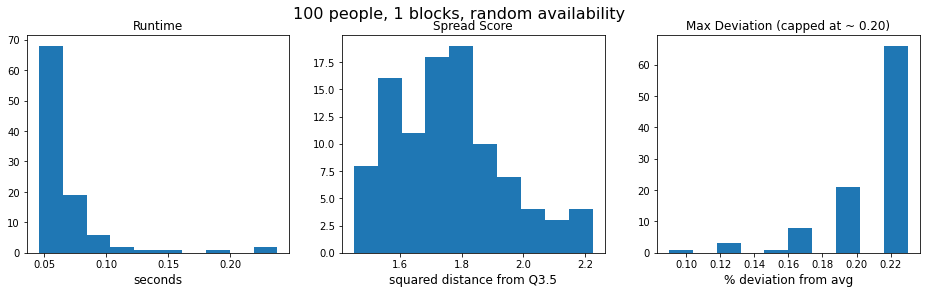

In [217]:
plotTrials(ts100, ss100, mds100, 0.2, 3.5, 100, 1, 100)

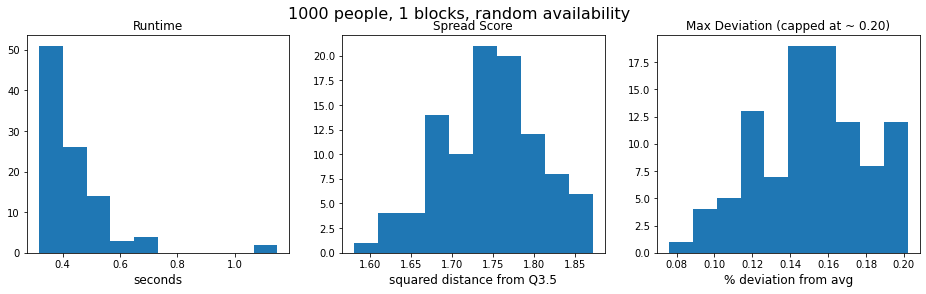

In [218]:
plotTrials(ts1000, ss1000, mds1000, 0.2, 3.5, 1000, 1, 100)

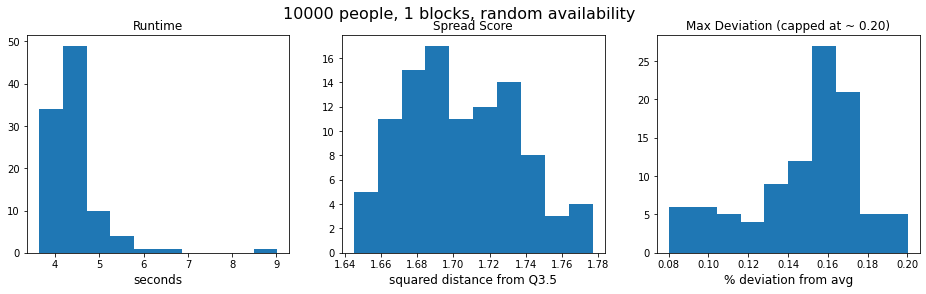

In [219]:
plotTrials(ts10000, ss10000, mds10000, 0.2, 3.5, 10000, 1, 100)

In [114]:
ts

[0.774445071999935,
 0.27145038399999066,
 0.149229245000015,
 0.09112261599989324,
 0.7248709149998831]

In [116]:
ts

[0.42040984900017975,
 0.4982518340000297,
 0.8006295870000031,
 0.5691357310001877,
 0.42324104700014686]

In [4]:
def make_avails_random(n_people, n_days, n_blocks):
    avail = np.random.randint(0,2, size=(n_people, n_blocks*n_days))
    
    # To check if someone is available at some point on each day
    avail_days = np.zeros((n_people, n_days))
    for i in range(n_people):
        for j in range(n_days):
            isAvail = False
            for k in range(n_blocks):
                if avail[i][j*n_blocks + k] == 1:
                    isAvail = True
            if isAvail:
                avail_days[i][j] = 1
    return avail, avail_days

def make_avails(student_pct, prof_pct, staff_pct):
    sum = student_pct + prof_pct + staff_pct
#     print("Sum of percents is %.02f (should be 1.00)" % sum)
    
    weeks = {'fully_avail':[1,1,1,1,1,1,1], 'mwf':[1,0,1,0,1,1,1], 'tth':[0,1,0,1,0,1,1],
             '1prof1':[1,0,0,0,0,0,0], '1prof2':[0,1,0,0,0,0,0], '1prof3':[0,0,1,0,0,0,0],
             '1prof4':[0,0,0,1,0,0,0], '1prof5':[0,0,0,0,1,0,0], '1prof1':[1,0,0,0,0,0,0],
             '2prof1':[1,0,1,0,0,0,0], '2prof2':[0,1,0,1,0,0,0], '2prof3':[0,0,1,0,1,0,0]}

    
    avail = np.zeros((n_people, n_days))
    for row in range(len(avail)):
        member = random.uniform(0,1)
        if member < student_pct: 
            studentAvail = random.uniform(0,1)
            if studentAvail < 0.7:
                avail[row] = weeks['fully_avail']
                continue
            else:
                flipCoin = random.uniform(0,1)
                if flipCoin < 0.5:
                    avail[row] = weeks['mwf']
                    continue
                else:
                    avail[row] = weeks['tth']
                    continue
        elif member < student_pct + prof_pct + staff_pct: # treat staff same as profs (for now)
            oneOrTwo = random.uniform(0,1)
            if oneOrTwo < 0.7: # 70% chance profs/staff are one campus 1x a week
                i = '1'
                day = str(random.randint(1,5))
                avail[row] = weeks[i + 'prof' + day]
                continue
            else:
                i = '2'
                day = str(random.randint(1,3))
                avail[row] = weeks[i + 'prof' + day]
                continue
    return avail

In [28]:
def runSetup(pcts, n_people, n_days, n_blocks, n_tests):
    # create random availability matrix
    avail, avail_days = make_avails_random(n_people, n_days, n_blocks) # truly random
#     avail = make_avails(pcts[0], pcts[1], pcts[2]) # more realistic -- not in parallel to random one!
    
    
    # Identify people who have infeasible availabilities
    people_total_availability = np.sum(avail_days, 1)
    infeasible_people = np.where(people_total_availability < n_tests)
    
    # If people have 2 or fewer available days, their schedule can't be shifted
    # to account for optimal spacing
    unshiftable_people = np.where(people_total_availability <= n_tests)

    # beq tracks how many tests people should take — 2 if possible, fewer if they're less available
    beq = np.multiply(n_tests, np.ones((n_people,))) # this could be changed!! to be better! dimensionality
    for i in range(len(infeasible_people[0])):
        beq[infeasible_people[0][i]] = people_total_availability[infeasible_people[0][i]]
        
    # Setup for the optimal spacing constraint — see optimization constraints below
    spaces = np.ones((n_people,))
    for i in range(len(unshiftable_people[0])):
        spaces[unshiftable_people[0][i]] += 1 

    # Calculate the average number of tests per day
    b_value = (n_people*n_tests/n_days)
    b = np.multiply(b_value, np.ones((n_days,)))
    
    # Calculate the average number of tests per block
    bb_value = b_value / n_blocks
    bb = np.multiply(bb_value, np.ones((n_blocks * n_days,)))
    
#     print(avail[0])
#     print(avail_days[0])
    
    return avail, b, beq, spaces, bb

In [91]:
def analyze(assignment, n_people, n_days, n_blocks, n_tests):
    
    sched_days = np.zeros((n_people, n_days))
    sched_blocks = assignment.value
#     print(sched_blocks[0])
    for i in range(n_people):
        for j in range(n_days):
            isAvail = False
            for k in range(n_blocks):
                if sched_blocks[i][j*n_blocks + k] == 1:
                    isAvail = True
            if isAvail:
                sched_days[i][j] = 1
#     print(sched_days.shape)
    
    # Compute spread score (lower is better)
    score = 0
    for week in sched_days:
#         print(week)
        scheduled_days = []
        for i in range(n_days):
            if week[i] == 1:
                scheduled_days.append(i)
        if len(scheduled_days) == 2:
            score += ((scheduled_days[1] - scheduled_days[0]) - (n_days / n_tests)) ** 2
#         print(score)
    spreadScore = score / n_people
    
    # Compute block demands, deviations
    block_demands = np.sum(assignment.value, axis=0)
    exp_supply_per_block = n_people * n_tests / (n_days * n_blocks)
    max_deviation = max(block_demands.max() - exp_supply_per_block,
                        exp_supply_per_block - block_demands.min()) / exp_supply_per_block # MIN, right?
    
    return spreadScore, block_demands, max_deviation

# constraints matrices

In [83]:
def make_constraints(n_days, n_blocks):
    consecs = np.zeros((n_blocks**2, 2*n_blocks))
    for i in range(n_blocks**2):
        for j in range(2*n_blocks):
            consecs[i][int(np.floor(i/n_blocks))] = 1
            consecs[i][int(n_blocks + np.floor(i%n_blocks))] = 1

    possible_adjs = (n_blocks**2) * (n_days-1)
    adjacencies = np.zeros((possible_adjs, 1*n_blocks * n_days)) # quadratic w. number of blocks
    for i in range(n_days - 1):
        adjacencies[(n_blocks**2) *i:(n_blocks**2) * (i+1), n_blocks*i:n_blocks*i + 2*n_blocks] = consecs

    sameDays = np.zeros((n_days, n_blocks*n_days))
    for i in range(len(sameDays)):
        idx = n_blocks*i
        for j in range(n_blocks):
            sameDays[i][idx + j] = 1
            
#     plt.imshow(sameDays)
#     plt.show()

#     plt.figure(num=1, figsize=(8,n_people/2))
#     plt.imshow(adjacencies, aspect='auto', extent=[0,n_blocks*n_days,(n_blocks ** 2) * (n_days - 1),0])
#     plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)
#     plt.xticks(np.arange(0,n_blocks * n_days, 1))
#     plt.yticks(np.arange(0, possible_adjs, 1))
#     plt.show()
    
    return adjacencies, sameDays

# cvxpy optimization

In [38]:
# n_days = 7
# n_people = 1000
# n_blocks = 6
# test_interval = 3.5 # corresponds to Qs_i
# n_tests = n_days / test_interval # corresponds to F_i
# buffer = .20

# avail, b, beq, spaces, bb = runSetup([.7,.2,.1], n_people, n_days, n_blocks, n_tests)

def runOpt(n_people, n_days, n_blocks, avail, bb, beq, spaces, buffer):
    assignment = cp.Variable((n_people, n_blocks * n_days), boolean=True)
    adjacencies, sameDays = make_constraints(n_days, n_blocks)

    # Working on an objective function to track schedule spacing
    # (not working right now, not implemented)
#     def objective():
#         expr = []
#         for i in range(n_days):
#             for j in range(i + 1, n_days):
#                 penalty = ((j - i) - test_interval)**2
#                 expr.append(penalty * cp.sum(assignment[:, i], assignment[:, j]))
#         expr.append(cp.sum(expr))

    constraints = [
        cp.sum(assignment, axis=0) <= np.ceil(bb * (1 + buffer)), # set load ub
        cp.sum(assignment, axis=0) >= np.floor(bb * (1 - buffer)), # set load lb
        cp.sum(assignment, axis=1) == beq, # enforce taking F_i tests
        cp.sum(cp.multiply(assignment, avail), axis=1) == beq # align with availability
    ]
    
    # Ensure that nobody is scheduled more than once each day
    for i in range(n_days):
        same = sameDays[i]*np.ones((n_people,1))
        constraints.append(cp.sum(cp.multiply(assignment, same), axis=1) <= np.ones((n_people,)))
    
    # Ensure each person has no consecutive days scheduled, unless that's all they can do
    for i in range(len(adjacencies)):
        consec = adjacencies[i]*np.ones((n_people,1))
        constraints.append(cp.sum(cp.multiply(assignment, consec), axis=1) <= spaces)

#     obj = cp.Minimize(objective()) # Spread objective function (not working)
    obj = cp.Maximize(cp.sum(assignment)) # Dummy objective function

    prob = cp.Problem(obj, constraints=constraints)
    prob.solve()

    return assignment

# assignment = runOpt(n_people, n_days, n_blocks)

# if assignment.value is not None:
#     spreadScore, block_demands, max_deviation = analyze(assignment, n_people, n_days, n_blocks)
#     print("Optimization done")
# else:
#     print("Situation infeasible")

# analysis

In [ ]:
print("Spread score is: %.02f" % spreadScore)
print("Max deviation %% is: %.01f" % (100 * max_deviation))
print('Block demand (min):', block_demands.min())
print('Block demand (max):', block_demands.max())
print('All block demands:', block_demands)
daily_demands = [sum(block_demands[i:i+3]) for i in range(0, blocks*n_days - 1, 3)]
print('All daily demands:', daily_demands)


if n_people <= 1000:
    # Display Calendar
    scaled_assignment = np.multiply(assignment.value, 0.5)
    data = np.add(scaled_assignment, avail)

    outputColors = colors.ListedColormap(['gray', 'red', 'yellow', 'green'])
    availColors = colors.ListedColormap(['gray', 'yellow'])

    plt.figure(num=1, figsize=(8,n_people/4))
    plt.title("Output Vector", fontsize=16)
    plt.imshow(data, cmap=outputColors, aspect='auto', extent=[0, n_days, n_people, 0])
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)
    plt.xticks(np.arange(0,n_days, 1))
    plt.yticks(np.arange(0, n_people, 1))

    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Person", fontsize=12)
    plt.savefig('output.png', dpi=300, bbox_inches='tight')
    plt.show()

# quantifications of performance

# running many trials
to check the distributions of spread scores, load balancing deviations

In [ ]:
%%time

spreads = []
devs = []
times = []
infeasible = 0
for t in range(500):
    if (t%50 == 0):
        print(t)
    avail, b, beq, spaces, bb = runSetup([.7,.2,.1])
    before = datetime.datetime.now()
    assignment = runOpt()
    after = datetime.datetime.now()
    times.append(after - before)
    if assignment.value is not None:
        spreadScore, daily_demands, max_deviation = analyze(assignment)
        spreads.append(spreadScore)
        devs.append(100 * max_deviation)
    else:
        infeasible += 1
print("There were %d infeasible situations" % infeasible)

In [ ]:
(sum(times, datetime.timedelta(0)) / len(times)).seconds + (0.000001) * (sum(times, datetime.timedelta(0)) / len(times)).microseconds

In [ ]:
ts = [t.seconds + (0.000001 * t.microseconds) for t in times]

In [ ]:
plt.hist(ts)
plt.xlabel("seconds")
plt.savefig("time_dist.png")
plt.show()

In [ ]:
plt.title("Distribution of Spread Scores, realistic schedules")
plt.hist(spreads)
plt.savefig('spreads_realistic_bounded.png', dpi=300, bbox_inches='tight')
plt.show()

plt.title("Distribution of Max Deviations (%), realistic schedules")
plt.hist(devs)
plt.savefig('maxDevs_realistic_bounded.png', dpi=300, bbox_inches='tight')
plt.show()